In [1]:
import subprocess
import shlex

import numpy as np

from matplotlib import pyplot as plt
from scipy.stats import binom
from matplotlib.colors import LinearSegmentedColormap

In [2]:
lookuptable = np.array([bin(i).count('1') for i in range(256)]).astype(np.int32)

def countbits(v):
    assert v.dtype in (np.uint8, np.uint16, np.uint32, np.uint64), 'must be an unsigned int dtype'
    
    return lookuptable[np.reshape(v.view(np.uint8), v.shape + (-1, ))].sum(axis=-1)

In [3]:
""" https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72 """

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

In [4]:
def test_rng_update_avalanche(seed=42, limit=1000):
    hash_differences = subprocess.run(shlex.split(
        f"cargo run --release --quiet -- --seed {seed} --limit {limit} {'update'}"
    ), check=True, capture_output=True, text=True)
    
    differences = np.fromstring(hash_differences.stdout, dtype="uint64", sep='\n')
    
    # Hamming distance histogram
    plt.hist(countbits(differences), bins=range(0, 65), density=True)

    x = np.linspace(0, 64, 65)
    p = binom.pmf(x, 64, 0.5)
    plt.plot(x, p, color='red', linewidth=2, alpha=0.5)

    plt.show()
    
    # Mean hamming distance
    print(np.mean(countbits(differences)) / 64)
    
    # Calculate bit dependence matrix
    bit_dependence = np.zeros(shape=(64, 64), dtype="uint64")
    bit_normalisation = np.zeros(shape=(64), dtype="uint64")

    for bit, difference in enumerate(differences):
        bit_normalisation[bit % 64] += 1

        mask = np.uint64(0x1)

        for b in range(0, 64):
            if difference & mask:
                bit_dependence[bit % 64, b] += 1

            mask <<= np.uint64(1)
    
    avalanche_probability_vector = bit_dependence.sum(axis=0) / len(differences)
    
    # Avalanche dependence: Satisfied iff == 64
    avalanche_dependence = 64 - np.sum(avalanche_probability_vector == 0.0)
    print(avalanche_dependence)
    
    # Avalanche weight: Satisfied iff ~~ 32
    avalanche_weight = np.sum(avalanche_probability_vector)
    print(avalanche_weight)
    
    # Avalanche entropy: Satisfied iff ~~ 64
    avalanche_entropy = np.sum(
        -avalanche_probability_vector * np.log2(avalanche_probability_vector)
        -(1.0 - avalanche_probability_vector) * np.log2(1.0 - avalanche_probability_vector)
    )
    print(avalanche_entropy)
    
    # Avalanche diagram
    plt.figure(figsize=(8, 8))
    plt.matshow(bit_dependence / bit_normalisation.reshape((64, 1)), cmap=get_continuous_cmap(['#000000', '#FF0000']), vmin=0.0, vmax=1.0, fignum=1)
    plt.show()

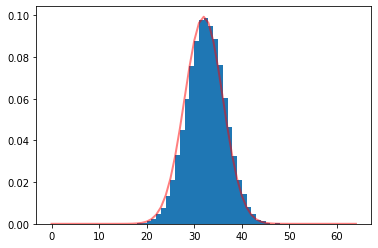

0.5002711861433383
64
32.01735591317366
63.99943549502898


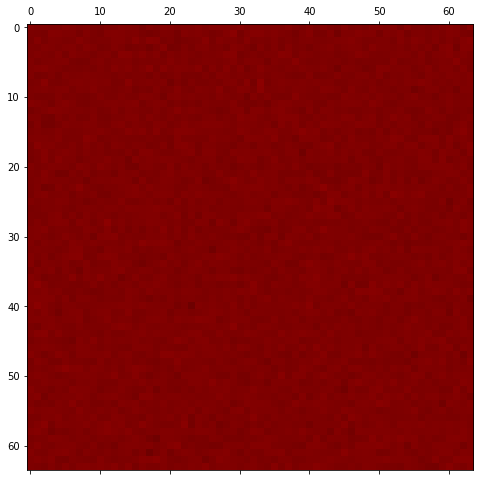

In [5]:
test_rng_update_avalanche(seed=42, limit=1000)

In [6]:
def test_rng_prime_avalanche(seed=42, limit=1000):
    hash_differences = subprocess.run(shlex.split(
        f"cargo run --release --quiet -- --seed {seed} --limit {limit} {'prime'}"
    ), check=True, capture_output=True, text=True)
    
    differences = np.fromstring(hash_differences.stdout, dtype="uint64", sep='\n')
    
    # Hamming distance histogram
    plt.hist(countbits(differences), bins=range(0, 65), density=True)

    x = np.linspace(0, 64, 65)
    p = binom.pmf(x, 64, 0.5)
    plt.plot(x, p, color='red', linewidth=2, alpha=0.5)

    plt.show()
    
    # Mean hamming distance
    print(np.mean(countbits(differences)) / 64)
    
    # Calculate bit dependence matrix
    bit_dependence = np.zeros(shape=(64*3, 64), dtype="uint64")
    bit_normalisation = np.zeros(shape=(64*3), dtype="uint64")

    for bit, difference in enumerate(differences):
        bit_normalisation[bit % (64*3)] += 1

        mask = np.uint64(0x1)

        for b in range(0, 64):
            if difference & mask:
                bit_dependence[bit % (64*3), b] += 1

            mask <<= np.uint64(1)
    
    avalanche_probability_vector = bit_dependence.sum(axis=0) / len(differences)
    
    # Avalanche dependence: Satisfied iff == 64
    avalanche_dependence = 64 - np.sum(avalanche_probability_vector == 0.0)
    print(avalanche_dependence)
    
    # Avalanche weight: Satisfied iff ~~ 32
    avalanche_weight = np.sum(avalanche_probability_vector)
    print(avalanche_weight)
    
    # Avalanche entropy: Satisfied iff ~~ 64
    avalanche_entropy = np.sum(
        -avalanche_probability_vector * np.log2(avalanche_probability_vector)
        -(1.0 - avalanche_probability_vector) * np.log2(1.0 - avalanche_probability_vector)
    )
    print(avalanche_entropy)
    
    # Avalanche diagram
    plt.figure(figsize=(8, 24))
    plt.matshow(bit_dependence / bit_normalisation.reshape((64*3, 1)), cmap=get_continuous_cmap(['#000000', '#FF0000']), vmin=0.0, vmax=1.0, fignum=1)
    plt.show()

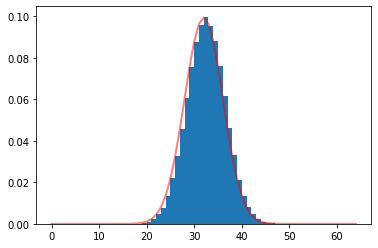

0.5001695827095808
64
32.01085329341317
63.999726496049405


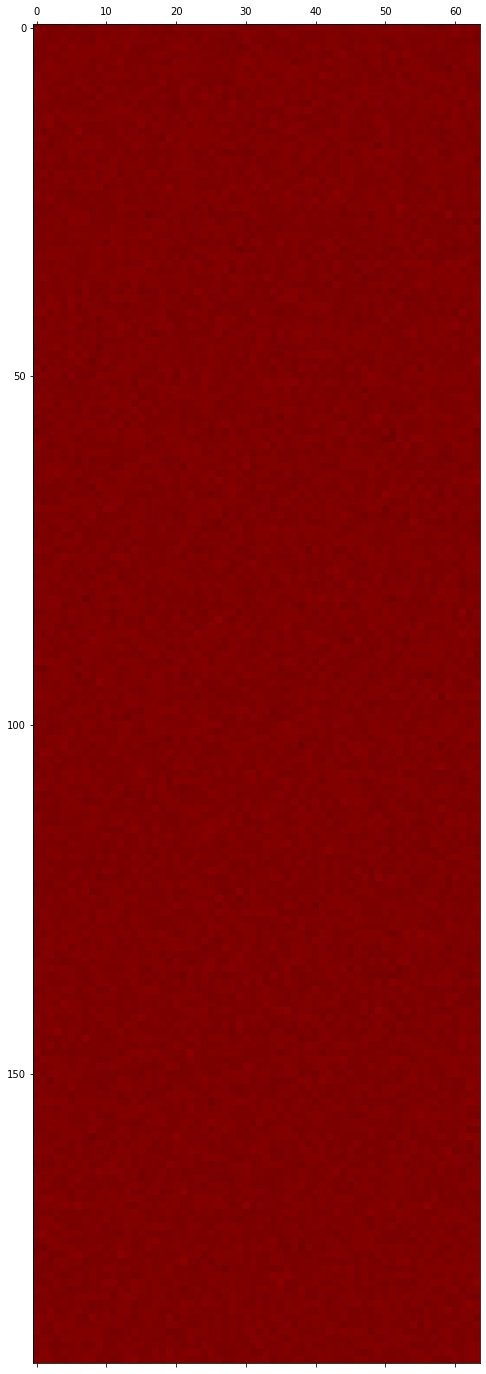

In [7]:
test_rng_prime_avalanche()